# Solving Titanic Kaggle Challenge with a Neural Network

In [1]:
!pip install wandb

In [2]:
!wandb login APIKEY

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\hammd/.netrc


In [45]:
import torch
from torch import nn
import torch.optim as optim

import pandas as pd
import os
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

import wandb
import argparse

## Choose a model

In [4]:
# Here we define our model
# It is a simple feedforward neural network

# Input Layer --> number of features from our dataset
# Hidden Layers
# Activation Function: ReLU (Rectified Linear Unit) --> this is for introducing non-linearity
# Output Layer: 1 neuron with a sigmoid activation function, representing the survival probability
class TitanicNN(nn.Module):
    def __init__(self, input_size):
        super(TitanicNN, self).__init__()

        # This is the first hidden layer with 128 neurons
        # It takes the input features and applies a linear transformation followed by the ReLU activation function
        self.fc1 = nn.Linear(input_size, 128)

        # Second hidden layer with 64 neurons. It takes the output of the first hidden layer and applies another
        # linear transformation followed by the ReLU activation function
        self.fc2 = nn.Linear(128, 64)

        # Output layer with 1 neuron. It takes the output of the second hidden layer and applies a linear transformation
        # followed by the sigmoid activation function.
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

#device = "cpu" # uncomment if you want to use "cpu", currently cpu is faster than cuda (maybe because the NN is very little)
print(f"Using {device} device")

number_of_featuers = 5
model = TitanicNN(number_of_featuers).to(device)
print(model)

Using cuda device
TitanicNN(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


## Choose a loss function

For binary classification tasks, the most common choice of loss function is the binary cross-entropy loss (log loss).

In [6]:
loss_function = nn.BCELoss()

## Initialize wandb

In [32]:
# Initialize wandb
# config hyperparameter (usually from command line) and let W&B know about them
# by using titanic-kaggle-train-test-find-param and wandb, I found out that using the following params performed best:
#config.learning_rate = 1e-3
#config.epochs = 10000
#config.batch_size = 4096
config = argparse.Namespace()
config.learning_rate = 1e-3
config.epochs = 10000
config.batch_size = 1024

In [33]:
wandb.init(project="kaggle-titanic", config=vars(config))

## Choose an optimizer

For tasks like this, the Adam optimizer is a widely used choice due to its adaptive learning rate and good performance in practice.

In [34]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# You can adjust the learning rate (lr) parameter in the optim.Adam call to control the step size during optimization.
# Experiment with different learning rates to find the one that works best for your specific task and model architecture.

## Train the model

In [35]:
# loads just the training data
# returns two DataFrames, one with just the features and one with the labels
def load_titanic_train_preprocessed():
    train_preprocessed = pd.read_csv(os.path.join('data', 'train_preprocessed.csv'))
    train_preprocessed_features = train_preprocessed.drop('Survived', axis=1)
    train_preprocessed_label = train_preprocessed['Survived']
    return train_preprocessed_features, train_preprocessed_label

In [36]:
train_features, train_labels = load_titanic_train_preprocessed()

# convert to PyTorch tensors
features_tensors = torch.tensor(train_features.values, dtype=torch.float32)
targets_tensors = torch.tensor(train_labels.values, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(features_tensors, targets_tensors)

# Define data loader
# It contains both the features and the labels
batch_size = config.batch_size
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [37]:
# Training loop
wandb.watch(model)
model.train(mode=True)

losses = []
for epoch in range(config.epochs):
    for batch_inputs, batch_targets in data_loader:
        # batch_inputs --> my features
        # batch_targets --> my expected labels

        # Clear gradients from previous iteration
        optimizer.zero_grad()

        # now we make predictions from our model
        batch_outputs = model(batch_inputs.to(device))

        # and we calculate the loss by comparing the predictions against our expected labels
        # since batch_targets has shape [32] (1 row, 32 cols) and batch_outputs has [32,1]
        # (32 rows, 1 col), we do an unsqueeze here to change the shape of batch_targets
        loss = loss_function(batch_outputs, batch_targets.unsqueeze(1).to(device))
        losses.append(loss.item())

        # Backpropagate gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

    print(f'Epoch [{epoch+1}/{config.epochs}], Loss: {loss.item()}')
    wandb.log({'epoch': epoch+1, 'loss': loss.item()})

model.eval()

Epoch [1/10000], Loss: 0.2231915146112442
Epoch [2/10000], Loss: 1.0376561880111694
Epoch [3/10000], Loss: 0.27252042293548584
Epoch [4/10000], Loss: 0.35920700430870056
Epoch [5/10000], Loss: 0.5902009606361389
Epoch [6/10000], Loss: 0.6065031886100769
Epoch [7/10000], Loss: 0.4844965636730194
Epoch [8/10000], Loss: 0.3529781103134155
Epoch [9/10000], Loss: 0.29697903990745544
Epoch [10/10000], Loss: 0.32412663102149963
Epoch [11/10000], Loss: 0.37335553765296936
Epoch [12/10000], Loss: 0.39653465151786804
Epoch [13/10000], Loss: 0.37673667073249817
Epoch [14/10000], Loss: 0.3269415497779846
Epoch [15/10000], Loss: 0.2864595055580139
Epoch [16/10000], Loss: 0.2738385498523712
Epoch [17/10000], Loss: 0.28680869936943054
Epoch [18/10000], Loss: 0.30600860714912415
Epoch [19/10000], Loss: 0.31237271428108215
Epoch [20/10000], Loss: 0.2992101311683655
Epoch [21/10000], Loss: 0.27275779843330383
Epoch [22/10000], Loss: 0.24578410387039185
Epoch [23/10000], Loss: 0.23348520696163177
Epoch [

TitanicNN(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

<Axes: >

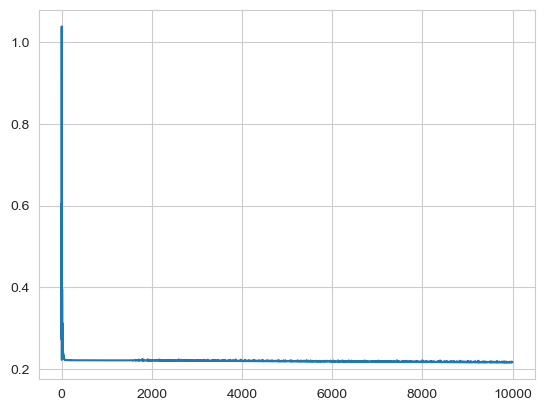

In [38]:
sns.lineplot(losses)

# Make predictions

In [39]:
# loads just the test data
# returns two DataFrames, one with just the features and one with the labels
def load_titanic_train_test_preprocessed():
    train_test_preprocessed = pd.read_csv(os.path.join('data', 'train_test_preprocessed.csv'))
    train_test_preprocessed_features = train_test_preprocessed.drop('Survived', axis=1)
    train_test_preprocessed_label = train_test_preprocessed['Survived']
    return train_test_preprocessed_features, train_test_preprocessed_label

In [40]:
def create_report(predictions, expected_labels):
    ConfusionMatrixDisplay.from_predictions(expected_labels, predictions)
    plt.show()
    print("The test score is ", accuracy_score(expected_labels, predictions))

    ## for the next methods:
    ## if pos_label is not given, it just calculates the f1_score for pos_label=1
    ## with average="weighted", we can define to calculate the average weighted for all labels
    ## with average="macro", we get the unweighted mean (label imbalance is not taken into account)


    ## precision score: TP / (TP + FP) ==> the more false positives I have, the smaller the precision score
    print("The precision score is ", precision_score(expected_labels, predictions, average="weighted"))

    ## recall score: TP / (TP + FN) ==> the more false negatives I have, the smaller the recall score
    print("The recall score is ", recall_score(expected_labels, predictions, average="weighted"))

    ## f1 score: combination of precision and recall score
    print("The f1 score is ", f1_score(expected_labels, predictions, average="weighted"))
    print(classification_report(expected_labels, predictions))

In [41]:
test_features, test_labels = load_titanic_train_test_preprocessed()

# convert to PyTorch tensors
test_features_tensors = torch.tensor(test_features.values, dtype=torch.float32)

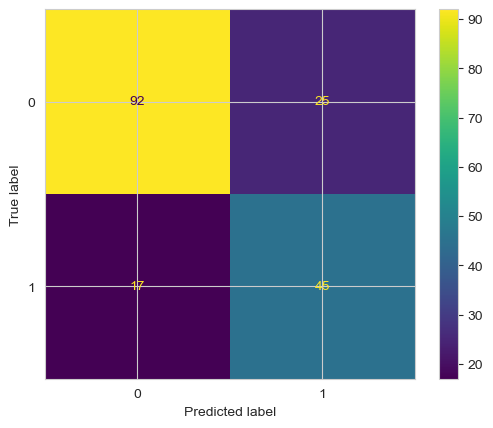

The test score is  0.7653631284916201
The precision score is  0.7743543934923157
The recall score is  0.7653631284916201
The f1 score is  0.7683204717366975
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       117
           1       0.64      0.73      0.68        62

    accuracy                           0.77       179
   macro avg       0.74      0.76      0.75       179
weighted avg       0.77      0.77      0.77       179



In [42]:
predicted_labels = model(test_features_tensors.to(device))

# The predicted_labels contain values between 0 and 1.
# We apply a threshold to make a binary classification.
threshold = 0.5
binary_predictions = [1 if prob >= threshold else 0 for prob in predicted_labels]
create_report(binary_predictions, test_labels)

In [43]:
wandb.log({"test_accuracy": f1_score(test_labels, binary_predictions, average="weighted")})

In [44]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▆▆▆▅▅▅▅█▆▆▅▆▅▅▄▄▄▅▄▄▃▄▄▄▄▃▂▂▃▂▂▂▂▂▁▁▂▂▁▁
test_accuracy,▁
epoch,10000
loss,0.21758
test_accuracy,0.76832


## Create Result for Kaggle

In [46]:
def load_titanic_test_preprocessed():
    test_preprocessed = pd.read_csv(os.path.join('data', 'test_preprocessed.csv'))
    test_preprocessed_features = test_preprocessed.drop('PassengerId', axis=1)
    test_preprocessed_label = test_preprocessed['PassengerId']
    return test_preprocessed_features, test_preprocessed_label

X_final, x_final_passenger_id = load_titanic_test_preprocessed()

# convert to PyTorch tensors
X_final_features_tensors = torch.tensor(X_final.values, dtype=torch.float32)

predicted_labels = model(X_final_features_tensors.to(device))

# The predicted_labels contain values between 0 and 1.
# We apply a threshold to make a binary classification.
threshold = 0.5
binary_predictions = [1 if prob >= threshold else 0 for prob in predicted_labels]

df_final = pd.DataFrame(x_final_passenger_id)
df_final["Survived"] = binary_predictions

filepath = Path('result.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_final.to_csv(filepath, index=False)